### Import required packages, set some settings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

### Generate regression dataset

/tmp/ipykernel_11825/2664038885.py:3: RuntimeWarning: divide by zero encountered in power
  return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x)**(-0.5)) -0.005*x**2


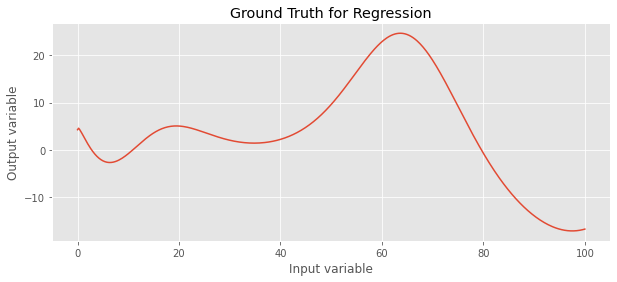

In [5]:
def ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x)**(-0.5)) -0.005*x**2

xs = np.linspace(0, 100, 500)
ys = ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

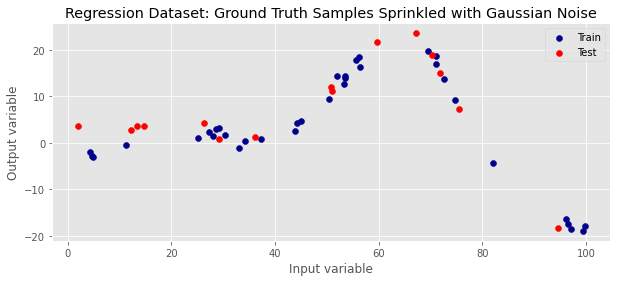

In [6]:
def generate_dataset(size=50, noise=1, split=0.3):
    xs = np.random.uniform(0, 100, size)
    ys = ground_truth(xs) + np.random.normal(0, noise, size)
    return train_test_split(xs, ys, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Control test: deterministic MLP

##### Build model

In [7]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 1),
)

loss = torch.nn.MSELoss()
opt = torch.optim.SGD(
    model.parameters(), 
    lr=0.0001,  # learning rate
    weight_decay=0.1  # l2 coefficient
)

##### Train model

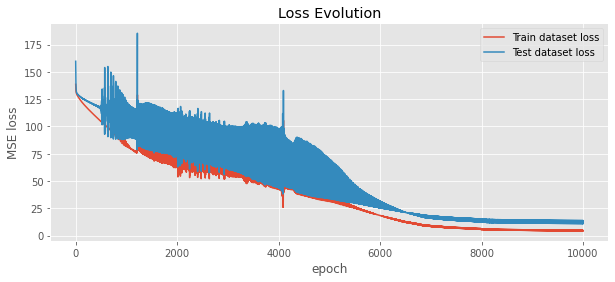

In [8]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(10000):  # epochs
    y_tr_pred = model(x_tr)
    l = loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())
    te_loss_evo.append(loss(model(x_te), y_te).item())
    model.zero_grad()
    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

/tmp/ipykernel_11825/2664038885.py:3: RuntimeWarning: divide by zero encountered in power
  return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x)**(-0.5)) -0.005*x**2


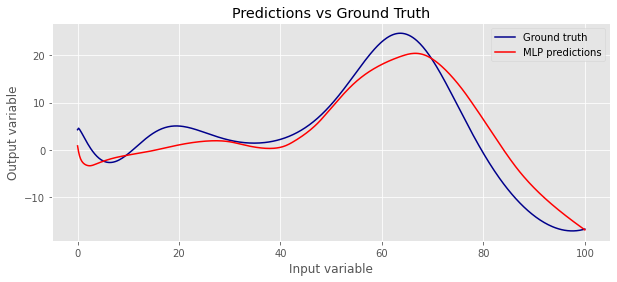

In [9]:
xs = np.linspace(0, 100, 500)
yps = model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()
ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.plot(xs, yps, color='red', label='MLP predictions')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()